# Data Loading/Preprocessing/Visualization

### Loading

In [1]:
import json
import numpy as np

# Load the data from the JSON file
with open('data/data.json') as f:
    data = json.load(f)

# Print the data content of the JSON file
print(f"Data is list of {len(data)} items")
print(f"Each item is a dictionary with keys: {data[0].keys()}")
print(f"The 'sequence' key is a list of {np.array(data[0]['sequence']).shape[0]} elements with 15x15=225 entries each")
print(f"When an items has label '1', the sequence contain at least one elements which has quanching")
print(f"The events with label '1' have also wich step of the sequece has the 'quench' label where it's stored the x,y,t position of the quenching event and the temperature")


Data is list of 3000 items
Each item is a dictionary with keys: dict_keys(['sequence', 'label'])
The 'sequence' key is a list of 24 elements with 15x15=225 entries each
When an items has label '1', the sequence contain at least one elements which has quanching
The events with label '1' have also wich step of the sequece has the 'quench' label where it's stored the x,y,t position of the quenching event and the temperature


### Preprocessing for data visualization

In [15]:
# Let's convert the data to a numpy array
dataPost = np.array([[np.array(item['sequence'][step]).reshape(15, 15) for step in np.arange(0, 24) ] for item in data]) #looping over sequences and reshaping each step of the sequence to 15x15
labels = np.array([item['label'] for item in data]) #looping over sequences and getting the label of each sequence 

# -------- quench label --------
quench = [item["quench"] if item['label'] == 1 else [{'step': -1, 'pixel': [-1, -1], 'temp': -1}] for item in data]
maxNquenches = max([len(item) for item in quench])
print(f"Max number of quenching events in a sequence: {maxNquenches}")
# Now let's modify the quench list in order to have an homogeneous shape for all the sequences
for i in range(len(quench)):
    while len(quench[i]) < maxNquenches:
        quench[i].append({'step': -1, 'pixel': [-1, -1], 'temp': -1})
quench = np.array(quench)
# Now let's convert it in a numpy structured array
dtype = np.dtype([('step', 'i4'), ('pixel_x', 'i4'), ('pixel_y', 'i4'), ('temp', 'f4')])
quenchPost = np.zeros((quench.shape[0], quench.shape[1]), dtype=dtype)

for i in range(quench.shape[0]):
    for j in range(quench.shape[1]):
        quenchPost[i, j] = (
            quench[i][j]['step'],
            quench[i][j]['pixel'][0],
            quench[i][j]['pixel'][1],
            quench[i][j]['temp']
        )
print(f"quenchPost shape: {quenchPost.shape}")
# ------------------------------                       #All this work is to have a more defined structure of the data, so we can use it in the model later on


print(f"quenchPost shape: {quench.shape}") # --> (n_sequences, maxNquenches)
print(f"dataPost shape: {dataPost.shape}") # --> (n_sequences, n_steps, 15, 15)
print(f"labels shape: {labels.shape}") # --> (n_sequences,)

Max number of quenching events in a sequence: 14
quenchPost shape: (3000, 14)
quenchPost shape: (3000, 14)
dataPost shape: (3000, 24, 15, 15)
labels shape: (3000,)


### Visualization

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

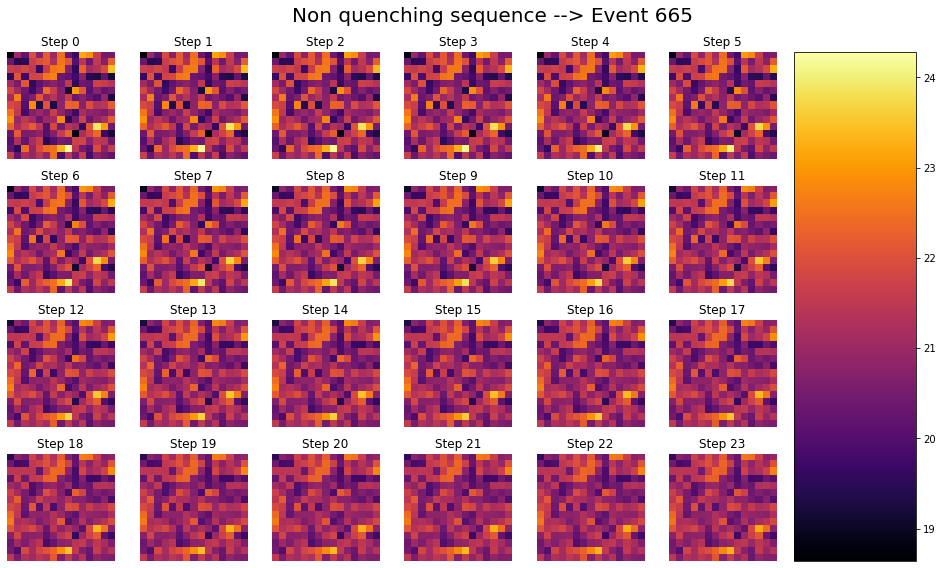

In [5]:
# -----------------Let's plot a non quenching sequence-------------------

idx = np.random.choice(np.where(labels == 0)[0])
vmin = dataPost[idx].min()
vmax = dataPost[idx].max()
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 7, figure=fig) 
axs = [fig.add_subplot(gs[i // 6, i % 6]) for i in range(24)]
for i, ax in enumerate(axs):
    im = ax.imshow(dataPost[idx, i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f"Step {i}")
fig.suptitle(f"Non quenching sequence --> Event {idx}", fontsize= 20)
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Aggiusta il layout per fare spazio alla colorbar
plt.show()



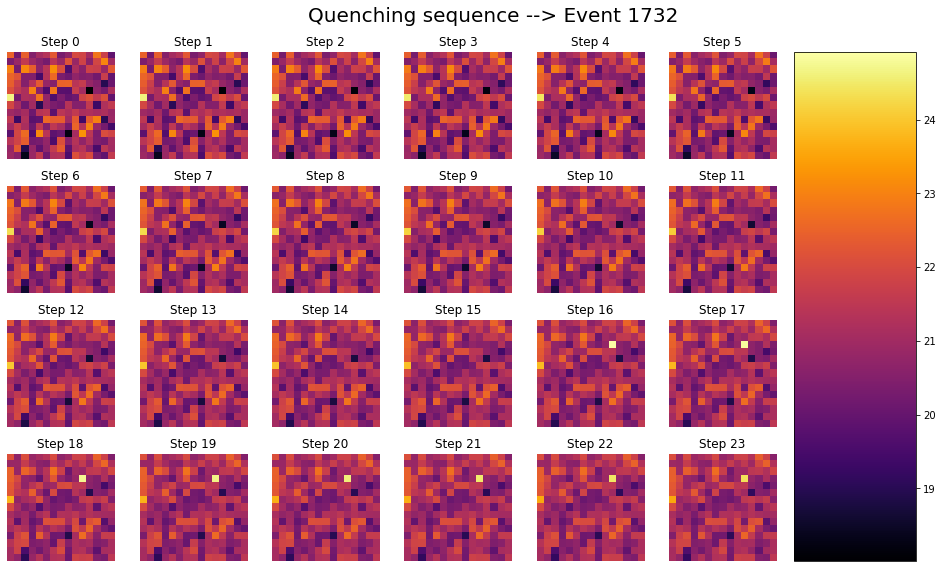

In [6]:
# -----------------Let's plot a quenching sequence-------------------

idx = np.random.choice(np.where(labels == 1)[0])
vmin = dataPost[idx].min()
vmax = dataPost[idx].max()
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(4, 7, figure=fig) 
axs = [fig.add_subplot(gs[i // 6, i % 6]) for i in range(24)]
for i, ax in enumerate(axs):
    im = ax.imshow(dataPost[idx, i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.axis('off')
    ax.set_title(f"Step {i}")
fig.suptitle(f"Quenching sequence --> Event {idx}", fontsize= 20)
cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Aggiusta il layout per fare spazio alla colorbar
plt.show()


# TASK 1: Identify if a sequence has quanches 

In [17]:
import dgl
import torch

# Let's create a graph for each sequence where each node is an image of the sequence
graphs = []

#let's first reshape the dataPost to have the shape (n_sequences, n_steps, 15*15)
dataPost = dataPost.reshape(dataPost.shape[0], dataPost.shape[1], -1)
print(f"Reshaped dataPost shape: {dataPost.shape}")

for i in range(dataPost.shape[0]):
    g = dgl.DGLGraph()
    g.add_nodes(dataPost.shape[1]) # Adding a node for each step of the sequence
    g.ndata['x'] = torch.tensor(dataPost[i], dtype=torch.float32) # Adding the features to each node
    # Adding edges fully connecting the nodes
    src, dst = [], []
    for j in range(dataPost.shape[1]):
        for k in range(dataPost.shape[1]):
            if j != k:
                src.append(j)
                dst.append(k)
    g.add_edges(src, dst)
    graphs.append(g)
    

#let's now normalize the features wrt the max value for each sequence
max_values = np.array([item.max() for item in dataPost])
for i in range(len(graphs)):
    graphs[i].ndata['x'] /= max_values[i]



Reshaped dataPost shape: (3000, 24, 225)


/Users/micheledandrea/opt/anaconda3/envs/nnwork/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


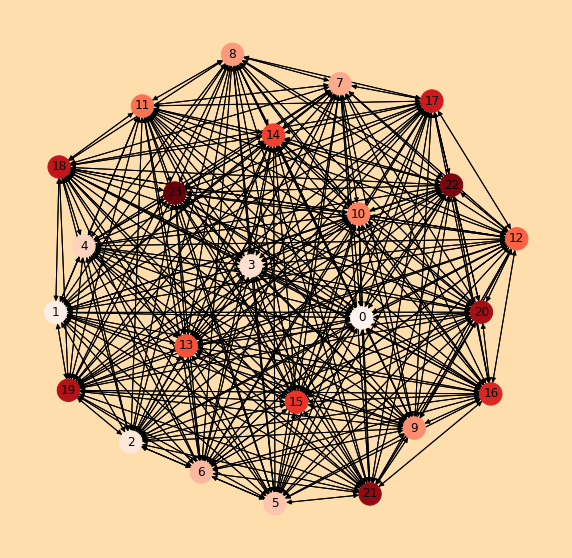

In [26]:
#Visualizing the graph of a sequence
import networkx as nx
import matplotlib.pyplot as plt

idx = np.random.choice(np.arange(len(graphs)))
G = graphs[idx].to_networkx()
pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(G, pos, node_color=range(dataPost.shape[1]), cmap=plt.cm.Reds, node_size=500, with_labels=True)
ax.set_facecolor('navajowhite')
ax.axis('off')
fig.set_facecolor('navajowhite')
plt.show()


### DataLoader

In [71]:
#let's define a data loader for the dataset
from torch.utils.data.sampler import WeightedRandomSampler


num_examples = len(dataPost)

num_train = int(num_examples * 0.8)
num_val = int(num_examples * 0.1)
num_test = num_examples - num_train - num_val

# Creating a weighted sampler for the training/val/test sets based on the labels
weights = 1 / np.bincount(labels)
weights /= weights.sum()
print(f"Class weights: {weights}")
weightsTensor = weights[labels]
print(f"Weighted labels: {weightsTensor}")

train_sampler = WeightedRandomSampler(weightsTensor[:num_train], num_train, replacement=True)
val_sampler = WeightedRandomSampler(weightsTensor[num_train:num_train+num_val], num_val, replacement=True)
test_sampler = WeightedRandomSampler(weightsTensor[num_train+num_val:], num_test, replacement=True)

print("\n#---------------TRAININGSET-----------------#")
print(f"Train sampler number of events: {len(train_sampler)}")
labels_train = labels[list(train_sampler)]
n_Unquench = len(labels_train[labels_train == 0])
n_Quench = len(labels_train[labels_train == 1])
print(f"Percentage of quenching events in the training set: {n_Quench / len(labels_train) * 100:.2f}%")
print(f"Percentage of non quenching events in the training set: {n_Unquench / len(labels_train) * 100:.2f}%")
print("#-----------------------------------------#\n")

print("\n#---------------VALIDATIONSET-----------------#")
print(f"Validation sampler number of events: {len(val_sampler)}")
labels_val = labels[list(val_sampler)]
n_Unquench = len(labels_val[labels_val == 0])
n_Quench = len(labels_val[labels_val == 1])
print(f"Percentage of quenching events in the validation set: {n_Quench / len(labels_val) * 100:.2f}%")
print(f"Percentage of non quenching events in the validation set: {n_Unquench / len(labels_val) * 100:.2f}%")
print("#-----------------------------------------#\n")

print("\n#---------------TESTSET-----------------#")
print(f"Test sampler number of events: {len(test_sampler)}")
labels_test = labels[list(test_sampler)]
n_Unquench = len(labels_test[labels_test == 0])
n_Quench = len(labels_test[labels_test == 1])
print(f"Percentage of quenching events in the test set: {n_Quench / len(labels_test) * 100:.2f}%")
print(f"Percentage of non quenching events in the test set: {n_Unquench / len(labels_test) * 100:.2f}%")
print("#-----------------------------------------#\n")


from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)
    
train_dataset = GraphDataset(graphs[:num_train], labels[:num_train])
val_dataset = GraphDataset(graphs[num_train:num_train+num_val], labels[num_train:num_train+num_val])
test_dataset = GraphDataset(graphs[num_train+num_val:], labels[num_train+num_val:])
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

batchSize = 10

train_loader = DataLoader(train_dataset, batch_size=batchSize, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=batchSize, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=batchSize, sampler=test_sampler)

#let's check the content of the data loader
for i, (g, l) in enumerate(train_loader):
    print(f"Batch {i}")
    print(f"Graphs shape: {g.batch_size}")
    print(f"Labels shape: {l.shape}")
    break

Class weights: [0.1 0.9]
Weighted labels: [0.1 0.1 0.1 ... 0.1 0.1 0.1]

#---------------TRAININGSET-----------------#
Train sampler number of events: 2400
Percentage of quenching events in the training set: 48.75%
Percentage of non quenching events in the training set: 51.25%
#-----------------------------------------#


#---------------VALIDATIONSET-----------------#
Validation sampler number of events: 300
Percentage of quenching events in the validation set: 8.33%
Percentage of non quenching events in the validation set: 91.67%
#-----------------------------------------#


#---------------TESTSET-----------------#
Test sampler number of events: 300
Percentage of quenching events in the test set: 13.67%
Percentage of non quenching events in the test set: 86.33%
#-----------------------------------------#

Train dataset size: 2400
Validation dataset size: 300
Test dataset size: 300


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'dgl.heterograph.DGLHeteroGraph'>